In [ ]:
!pip install timm
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 984.7 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

In [ ]:
import os
import time

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
torch.cuda.is_available()

False

In [ ]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [ ]:
img_size = 1000
LR = 1e-3
EPOCHS = 1
BATCH_SIZE = 32
num_workers = 0

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    ## 긴 쪽을 img_size에 맞추고 비율 유지
    #A.LongestMaxSize(max_size=img_size),
    ## 나머지 부분을 패딩으로 채움
    #A.PadIfNeeded(min_height=img_size, min_width=img_size,
    #              border_mode=0, value=(0,0,0)),  # 검은색으로 패딩
    ## images normalization
    #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    #A.LongestMaxSize(max_size=img_size),
    #A.PadIfNeeded(min_height=img_size, min_width=img_size,
    #              border_mode=0, value=(0,0,0)),
    #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [16]:
# 구글 드라이브 마운트, Colab을 이용하지 않는다면 패스해도 됩니다.
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
drive.mount('/content/drive')

Mounted at /gdrive
Mounted at /content/drive


In [18]:
# 구글 드라이브에 업로드된 대회 데이터를 압축 해제하고 로컬에 저장합니다.
!tar -xvf drive/MyDrive/data.tar.gz > /dev/null

In [20]:
# Dataset 정의
trn_dataset = ImageDataset(
    "data/train.csv",
    "data/train/",
    transform=trn_transform
)
tst_dataset = ImageDataset(
    "data/sample_submission.csv",
    "data/test/",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

1570 3140


In [21]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np

def visualize_dataset(dataset, set_number=1, num_images=10, is_train=True, dist=False):
    total_images = len(dataset)
    start_index = (set_number - 1) * num_images
    end_index = min(start_index + num_images, total_images)

    # 이미지와 라벨 가져오기
    images = []
    labels = []
    for i in range(start_index, end_index):
        img, label = dataset[i]
        images.append(img)
        labels.append(label)

    # 그리드 생성을 위한 figure 설정
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    # 라벨의 유니크한 값 확인
    unique_labels = set(labels)
    label_names = {label: f'Class {label}' for label in unique_labels}

    for i, (img, label) in enumerate(zip(images, labels)):
        # 이미지 표시 (정규화 해제 없이)
        img_np = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].axis('off')

        actual_index = start_index + i
        if is_train:
            # 라벨 표시 (훈련 데이터인 경우)
            axes[i].set_title(f"Class {label} (Index: {actual_index})")
        else:
            axes[i].set_title(f"Index: {actual_index}")

    # 남은 축 제거
    for i in range(len(images), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    if is_train & dist:
        # 전체 데이터셋의 라벨 분포 출력
        all_labels = [dataset[i][1] for i in range(total_images)]
        label_counts = pd.Series(all_labels).value_counts()
        print("Label Distribution in Entire Dataset:")
        for label, count in label_counts.items():
            print(f"Class {label}: {count} ({count/total_images*100:.2f}%)")

Training Dataset:


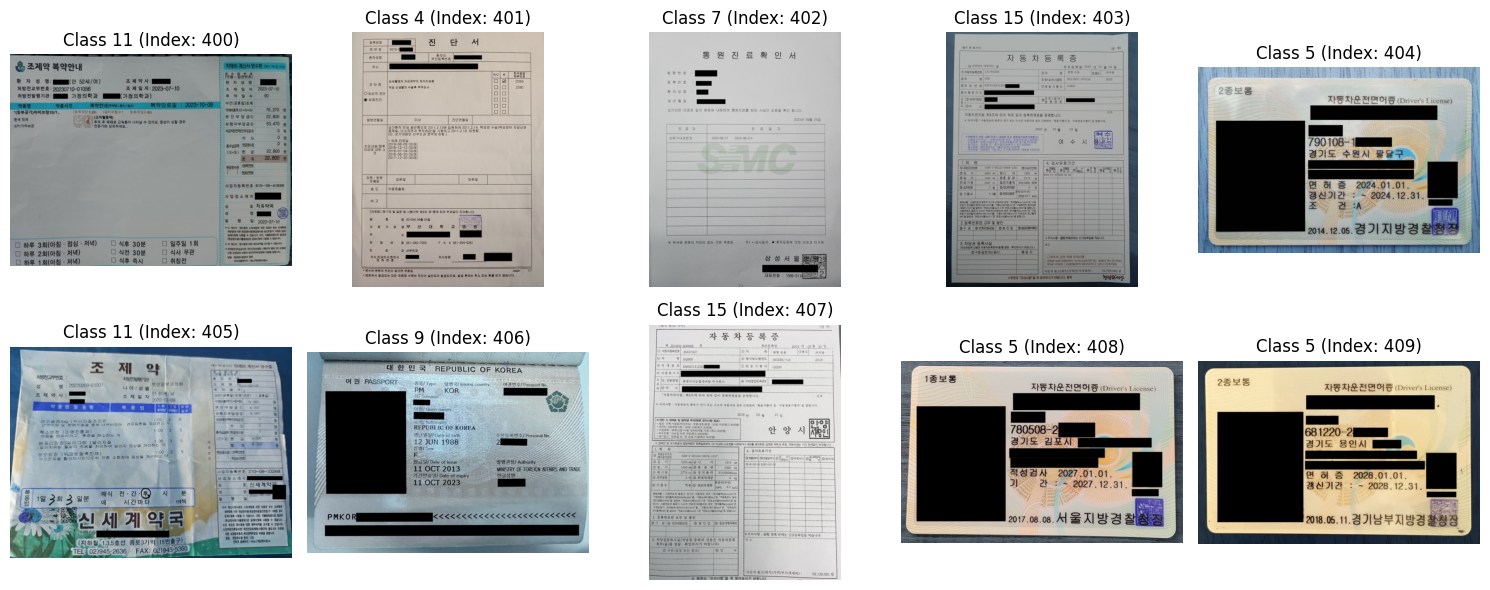

In [28]:
# 훈련 데이터셋 시각화
print("Training Dataset:")
visualize_dataset(trn_dataset, 41)

target,class_name

0,account_number

1,application_for_payment_of_pregnancy_medical_expenses

2,car_dashboard

3,confirmation_of_admission_and_discharge

4,diagnosis

5,driver_lisence

6,medical_bill_receipts

7,medical_outpatient_certificate

8,national_id_card

9,passport

10,payment_confirmation

11,pharmaceutical_receipt

12,prescription

13,resume

14,statement_of_opinion

15,vehicle_registration_certificate

16,vehicle_registration_plate


Test Dataset:


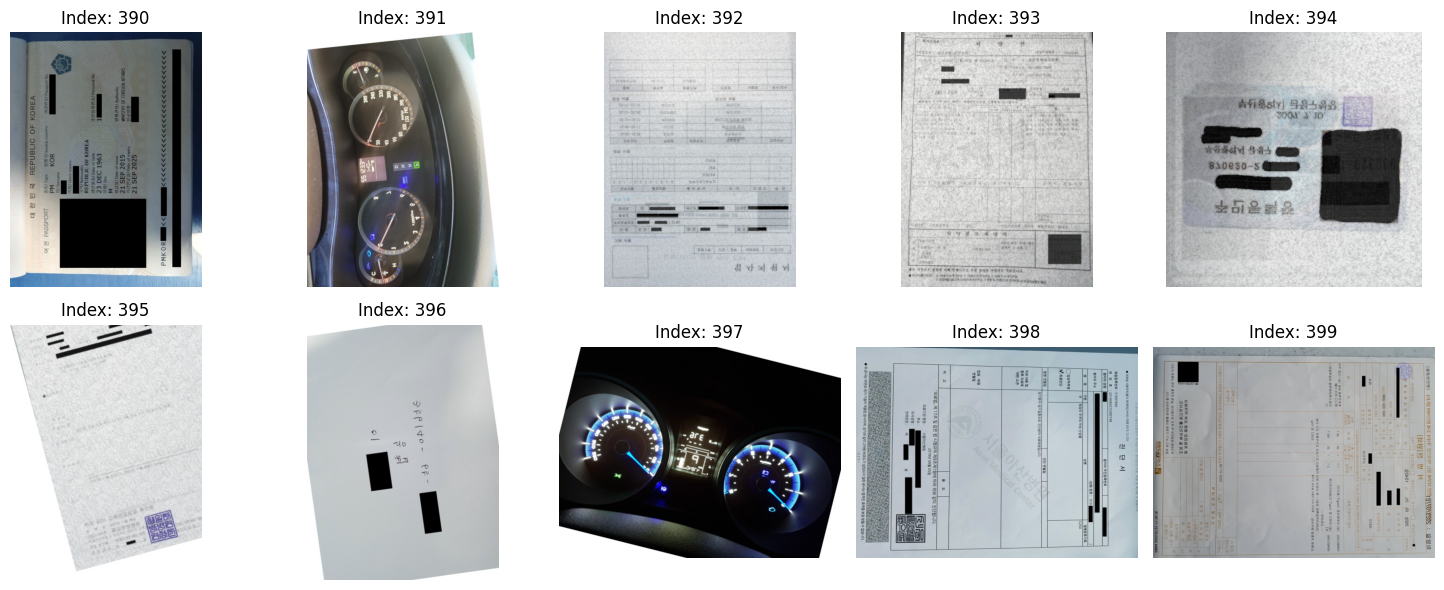

In [26]:
# 테스트 데이터셋 시각화
print("\nTest Dataset:")
visualize_dataset(tst_dataset,40, is_train=False)


Checking image sizes in the training dataset:

Image Size Distribution:
            Height        Width
count  1570.000000  1570.000000
mean    538.169427   497.613376
std      76.074772    79.370316
min     348.000000   384.000000
25%     443.000000   443.000000
50%     591.000000   443.000000
75%     591.000000   591.000000
max     682.000000   753.000000


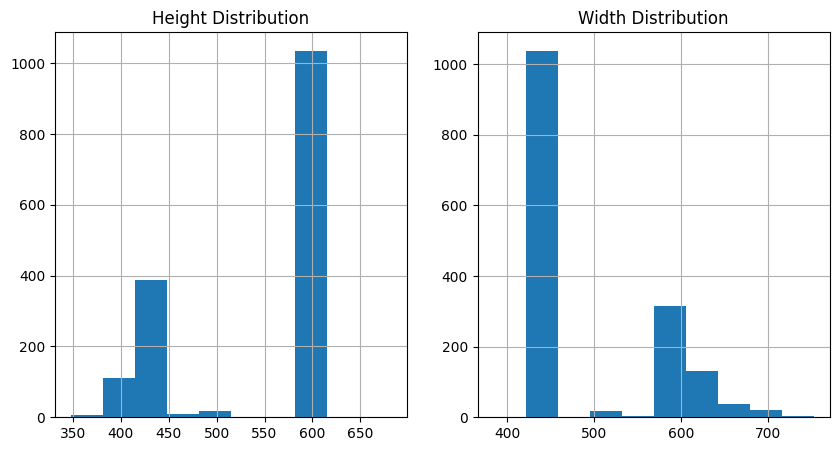

In [27]:
# 추가적인 EDA: 이미지 크기 분포 확인
def check_image_sizes(dataset):
    sizes = []
    for i in range(len(dataset)):
        img, _ = dataset[i]
        sizes.append(img.shape[1:])  # (height, width)

    sizes_df = pd.DataFrame(sizes, columns=['Height', 'Width'])
    print("\nImage Size Distribution:")
    print(sizes_df.describe())

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sizes_df['Height'].hist()
    plt.title('Height Distribution')
    plt.subplot(1, 2, 2)
    sizes_df['Width'].hist()
    plt.title('Width Distribution')
    plt.show()

print("\nChecking image sizes in the training dataset:")
check_image_sizes(trn_dataset)